In [1]:
# Packages -----------------
import os
import sys
import shutil
import warnings
import datetime

import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import seaborn as sns
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/Pedophysics_code')
sys.path.insert(0, 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code')

from pedophysics import predict, Soil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr
from scipy.optimize import minimize, differential_evolution
from IPython.display import clear_output
from utils.spatial_utils import utm_to_epsg, get_coincident
!pip install pymel
import pymel
from FDEM import Initialize
from utils.profile_utils import merge_layers, plot_profile, check_uniformity_and_interpolate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from PyPDF2 import PdfMerger
from emagpy import Problem

# Electromagnetic induction data inversion package
from plots import *
from PM import *
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.future.infer_string = True
import numpy as np
from scipy import constants

sys.path.insert(0,'../src/') # this add the emagpy/src directory to the PATH

# Configure input

In [2]:
# User input
s_site = 'P'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
em_intype = 'rECa'   # 'reca', 'LIN' 
cal = 'calibrated' # 'non_calibrated', 'drift_calibrated'
instrument_code = '21HS' # 421S, '21HS'
soil_analyses = 'soil_analyses'

# User input
config = {}

only_samples = False

# Sensor settings
config['instrument_code'] = 'Dualem-21HS' # instrument code
config['instrument_height'] = 0.165     # instrument height
config['instrument_orientation'] = 'HCP'    # instrument orientation

# Remove coils for inversion?
config['remove_coil'] = True    # set to True if you want to remove coils in the inversion process
config['coil_n'] = [0,1]    # indexes of coils to remove (cf. emagpy indexing)
                            # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                            # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

# Inversion parameters
config['fs_emp'] = 'FSeq' #'CS', 'FSlin' or 'FSeq'
config['opt_method'] = 'ROPE'  # mMinimize = ['L-BFGS-B','TNC','CG','Nelder-Mead'] --> https://docs.scipy.org/doc/scipy/reference/optimize.html 
                                # mMCMC = ['ROPE','DREAM', 'MCMC'] # ??? 'SCEUA' ??? --> https://spotpy.readthedocs.io/en/latest/ 
                                # mOther = ['ANN','Gauss-Newton','GPS'] (ANN requires tensorflow)
config['constrain']=True
config['regularization'] = 'l1'
config['alpha'] = 0

# Reference profile for starting model (conductivity values)
config['start_avg'] = True     # take average of input resistivity profiles per layer as starting model
                                # if false, reference profile is taken as starting model

# Define the interfaces depths between layers for starting model and inversion
#           (number of layers = len(config['interface'])+1)
config['n_int'] = True # if True custom interfaces are defined (via config['interface']), 
                        # otherwise reference profile interfaces are used

config['interface'] = [0.3, 0.6, 1.0, 2.0, 'end']

config['custom_bounds'] = True
config['bounds'] = [(10, 55), (20, 120), (50, 335), (50, 250), (10, 50)]

if config['constrain']:
    if config['custom_bounds']:
        bounds = config['bounds']


if config['n_int'] == False and config['custom_bounds']:
    print('Check if bounds and number of interfaces match')

# Geographic operations (if needed)
c_transform = False
c_utmzone = '31N'
c_target_cs = 'EPSG:31370'

# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

## Load data

In [3]:
if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if instrument_code == '21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)

s_site = 'P'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
datafolder = 'data' # data folder
em_intype = 'rECa'   # 'rec' = rECa transect; 'lin' = LIN ECa transect; 
                    # 'survey' = rEC full survey

cal_folder = os.path.join(datafolder, cal)
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_{cal}_{em_intype}.csv')
sam_folder = os.path.join(datafolder, soil_analyses)
samplocs = os.path.join(sam_folder, f'{profile_prefix}_sampledata.csv')
#inv_s = os.path.join(datafolder, f'{profile_prefix}_inverted_samples_{instrument_code}c.csv')
inv_folder = os.path.join(datafolder, 'inverted')
os.makedirs(inv_folder, exist_ok=True) 

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
em_survey = pd.read_csv(em_survey, sep=',', header=0)
#inverted = pd.read_csv(inv_s, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)
print('em_survey.head()', em_survey.head())
print('samples.head()', samples.head())


instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                    instrument_orientation=config['instrument_orientation']
                                    )

# Column names for emapgy input
emp_21HS = [f"HCP0.5f9000{config['instrument_height']}", 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165',
            'HCP0.5f9000h0.165_inph', 'PRP0.6f9000h0.165_inph', 'HCP1.0f9000h0.165_inph',
            'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph'
            ]

emp_421S = ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165', 
            'HCP1.0f9000h0.165_inph', 'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph',
            'HCP4.0f9000h0.165_inph', 'PRP4.1f9000h0.165_inph',
            ]

em_samples = get_coincident(em_survey, samples)

#if c_transform:
    # Create a new filename with the target EPSG code
#    em_rec = utm_to_epsg(em_rec, c_utmzone, target_epsg=c_target_cs)
##    em_lin = utm_to_epsg(em_lin, c_utmzone, target_epsg=c_target_cs)
#    em_survey = utm_to_epsg(em_survey, c_utmzone, target_epsg=c_target_cs)

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                        instrument_orientation=config['instrument_orientation']
                                        )

print(samples.head())
print(em_survey.head())

em_samples = get_coincident(em_survey,samples)

em_survey.head()                x              y      z         t      HCPHQP      PRPHQP  \
0  107775.418001  183252.432351  28.55  40376.03  178.202938  122.666572   
1  107775.418002  183252.432351  28.55  40376.12  178.202938  122.666572   
2  107775.418002  183252.432351  28.55  40376.21  178.202938  122.666572   
3  107775.418003  183252.432351  28.55  40376.31  177.709112  122.666572   
4  107775.418004  183252.432351  28.55  40376.41  177.462220  122.666572   

       HCP1QP      PRP1QP      HCP2QP      PRP2QP    HCPHIP    PRPHIP  \
0  216.258416  168.209524  186.540978  183.249567  0.980775  1.005246   
1  216.258416  168.209524  186.540978  183.249567  0.980775  1.005246   
2  216.258416  168.209524  186.540978  183.249567  0.980775  1.005246   
3  216.258416  168.209524  186.540978  183.249567  0.980775  1.005246   
4  216.258416  168.209524  186.540978  183.249567  0.980775  1.005246   

     HCP1IP    PRP1IP    HCP2IP    PRP2IP  
0  1.112987  0.423431  1.941012 -2.145315  

In [4]:
# config['reference_profile'] = 11

#if config['reference_profile'] not in all_profiles_df['ID'].unique():
#    warnings.warn("Warning: the reference profile ID does not exist. Provide correct profile ID.")
#    raise KeyboardInterrupt
#else:
#    profile_id = config['reference_profile']

# Create new layer configuration for prior model based on ERT data
#if config['n_int']:
#    new_int = config['interface']
#    merged_df = merge_layers(all_profiles_df, new_int,'EC(mS/m)')
#else:
#    merged_df = all_profiles_df
#comparedf = merged_df.copy()

# Plot original and (merged and) DC corrected reference profile
if config['n_int']:
    plot_title = 'Original vs merged & DC corrected data'
    first_in = .1
else: 
    plot_title = 'Original vs DC corrected data'
    first_in = .0
#ert_eval = ert_final.copy()
#ert_eval['z'] = ert_eval['z'].values + first_in

#plot_profile(ert_eval, profile_id, dataset_name, compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', block=True, plot_title=plot_title)
#plot_profile(ert_eval, profile_id, dataset_name, compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', plot_title=plot_title)

# Get prior model info
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = abs(group[depth_col].diff().iloc[1])
        #print(uniform_interval)
        num_layers = len(group[res_col])
                # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        con = group[res_col].values/1000
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)
        sus = np.zeros(num_layers)
        # Create model instance
        M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

#models = generate_forward_model_inputs(merged_df, 'ID', 'z', 'EC(mS/m)')

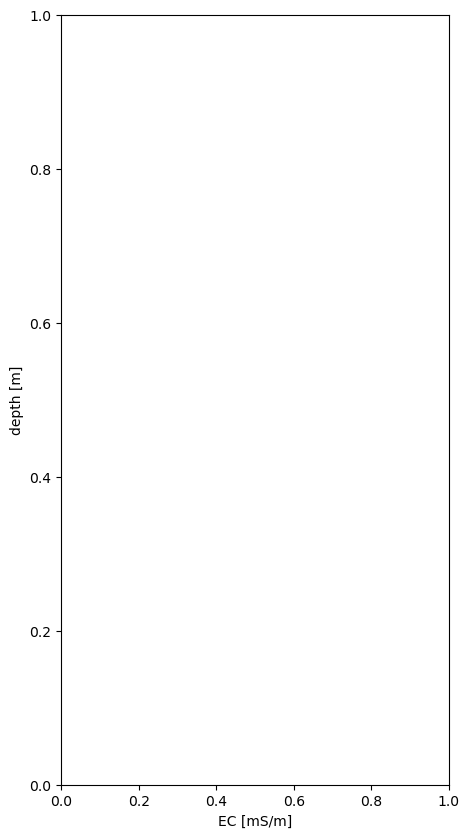

In [5]:
# 
# -------------------------------------------------------------------- #

# 
#profile_data = merged_df[merged_df['ID'] == profile_id].copy()
res_col = 'EC(mS/m)'
depth = 'z'

# 
# ------------------------------------------------------------------------------

# A. Test run on the reference profile (config['reference_profile'])
#       and plot the results

#if not config['n_int']:
##    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
#    second_lay = profile_data[depth].iloc[-2].round(decimals=1)
#    if first_lay == 0:
#        profile_data[depth]=profile_data[depth] +second_lay
#    else:
#        profile_data[depth]=profile_data[depth] +first_lay
##    thick = -profile_data[depth].iloc[1:].values
    #thick = -profile_data[depth].values
#else:
##    thick = -profile_data[depth].values

#con = profile_data[res_col].values/1000
#ref_len = len(con)
#num_layers = len(con)
#perm = np.full(num_layers, constants.epsilon_0)
#sus = np.zeros(num_layers)

# # Create model instance
#M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])

# ----------------------------------------------------------------------

dataset_name = 'EC(mS/m)'
#layers_interfaces = np.cumsum(models[profile_id].thick)
#layers_interfaces = np.insert(layers_interfaces, 0, 0)

fig, axr = plt.subplots(figsize=(5, 10))
axr.set_xlabel('EC [mS/m]')
axr.set_ylabel('depth [m]')
#axr.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
#if not config['n_int']: 
#    axr.plot(con[:-1]*1000,-thick, '.', label='Model EC 9khz',color = 'red')
#else:
#    axr.plot(con*1000,-thick, '.', label='Model EC 9khz',color = 'red')
##axr.set_title(f'Reference profile: ID {profile_id}')

#conductivities = con*1000

ec_cols_ref = []
if 'end' in config['interface']:
    config['interface'].remove('end')
# Get conductivity stats for bounds
if config['n_int']:
    if 'end' in ec_cols_ref:
        ec_cols_ref.remove('end')
    ec_cols_ref = config['interface']
    ec_cols_ref.append('end')
#    mod_layers = thick[1:]
#else:
#    if len(conductivities) == len(thick):
#        mod_layers = thick[1:]
#        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
#    elif len(conductivities) == (len(thick)+1):
#        mod_layers = thick
#        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
#    else:
#        raise ValueError(f"Check length of conductivities ({len(conductivities)}) and layers ({len(thick)}) arrays!!")
    
#    ec_cols_ref = np.round(layers_interfaces,decimals=1).tolist()
#ec_df = pd.DataFrame(columns=ec_cols_ref)

# 
#for i in merged_df['ID'].unique(): 
#    profile_data = merged_df[merged_df['ID'] == i].copy()
#    if not config['n_int']:
#        if abs(profile_data.iloc[0]['z']) > max((list(map(abs, ec_cols_ref)))):
            #print(f'removed {profile_data.iloc[0]["z"]}')#
#            profile_data = profile_data.drop(profile_data.iloc[0].name)
#        elif abs(profile_data.iloc[-1]['z']) < 0.1:
            #print(f'removed {profile_data.iloc[-1]["z"]}')
#            profile_data = profile_data.drop(profile_data.iloc[-1].name)
#    res_col = 'EC(mS/m)'
#    depth = 'z' 
#    con_m = profile_data[res_col].values
#    layers_interfaces = np.cumsum(models[i].thick)
#    layers_interfaces = np.insert(layers_interfaces, 0, 0)
#    num_layers = len(con)
#    perm = np.full(num_layers, constants.epsilon_0)
#    sus = np.zeros(num_layers)

#    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
#    second_lay = profile_data[depth].iloc[-2].round(decimals=1)

#    if not config['n_int']:
#        first_lay = profile_data[depth].iloc[-1].round(decimals=1)
#        second_lay = profile_data[depth].iloc[-2].round(decimals=1)
#        if first_lay == 0:
#            profile_data[depth]=profile_data[depth] +second_lay
#        else:
#            profile_data[depth]=profile_data[depth] +first_lay
#        thick = -profile_data[depth].iloc[1:].values
#    else:
#        thick = -profile_data[depth].values

#    ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])

#ec_df.reset_index(drop=True, inplace=True)

#ec_stats = ec_df.describe().loc[['min', 'max', 'std', '50%', 'mean']]
#ec_stats.rename(index={'50%': 'median'}, inplace=True)
#ec_stats.loc['min_sd'] = ec_stats.loc['min'] - 2 * ec_stats.loc['std']
#ec_stats.loc['max_sd'] = ec_stats.loc['max'] + 2 * ec_stats.loc['std']

#position = -thick


# define parameters for inversion starting model
# --------------------------------------------- #

#if not config['n_int']:
#    minstat = np.flipud(ec_stats.loc['min'].values[1:])
#    maxstat = np.flipud(ec_stats.loc['max'].values[1:])
#    start_mod = ec_stats.loc['mean'].values[1:]
#    boundcols = ec_cols_ref[:-1]
#else:
#    minstat = np.flipud(ec_stats.loc['min'].values)
#    maxstat = np.flipud(ec_stats.loc['max'].values)
#    start_mod = ec_stats.loc['mean'].values

#axr.plot(np.flipud(start_mod),position, 
#            '*', 
#            label='average conductivity',
#            color = 'green',
#            alpha = 0.5)
#axr.plot(minstat,position, 
#            '.', 
#            label='min',
#            color = 'black',
#            alpha = 0.2)
#axr.plot(maxstat,position, 
#            '+', 
#            label='max',
#            color = 'black',
#            alpha = 0.25)

#axr.legend()
#if config['constrain']:
#    if config['custom_bounds']:
#        bounds = config['bounds']
#    else:
#        bounds = []
#        for i, name in enumerate(ec_cols_ref):
#            if ec_stats.loc['min_sd'][name] > 0:
#                min = ec_stats.loc['min_sd'][name]
#           elif ec_stats.loc['min'][name] > 0:
#                min = ec_stats.loc['min'][name]
#            else:
#                min = 10
#            max = ec_stats.loc['max_sd'][name]
#            min_max = tuple([min,max])
#            bounds.append(min_max)
#        bounds = np.round(bounds, decimals=0)
#        if not config['n_int'] and not config['custom_bounds']:
#            bounds = bounds[1:]
#        print(f'autobounds = {bounds}')

In [6]:
# Perform inversion on sampling locations (to be used in pedophysical modelling)

if 'code' in em_samples.columns:
    em_samples = em_samples.rename(columns={'code': 'ID'})

# if config['n_omit'] != 0:
#     unique_ids = em_input['ID'].unique()
#     print(unique_ids)
#     selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
#     em_input = em_input.loc[em_input['ID'].isin(selected_ids)]

temp_dir = 'temp_emp' 
infile_name = 'infile.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
n = 4
em_samples.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_samples.columns.values[n:n+i] = new_columns

em_samples.to_csv(temp_file)

# transect inversion settings

s_rec = Problem()
s_rec.createSurvey(temp_file)
#t_rec.rollingMean(window=12)

#s_rec.setInit(
#    depths0=np.flipud(mod_layers),
#    conds0=conductivities
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
#    )
#print(np.flipud(mod_layers), conductivities)

#shutil.rmtree(temp_dir)

#if config['remove_coil']:
#    if type(config['coil_n']) == list:
#        config['coil_n'] = sorted(config['coil_n'])
#        for i in enumerate(config['coil_n']):
#            r_coil = s_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
#            s_rec.removeCoil(config['coil_n'][i[0]]-i[0])
#    else:
#        s_rec.removeCoil(config['coil_n'])

#print(f'Data used for inversion: {s_rec.coils}')

In [10]:
# invert using ROPE solver (RObust Parameter Estimation)

warnings.filterwarnings('ignore')
opt_meth = config['opt_method']
inv_meth = config['fs_emp']
reg_meth = config['regularization']
alph_param = config['alpha']

if opt_meth in ['MCMC', 'ROPE']:
    if config['constrain']:
        print(type(bounds), np.array(bounds), 'bounds')

        print(f'Constrained inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
                regularization=reg_meth, alpha=alph_param, 
                bnds=np.array(bounds)
                )
    else:
        print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
        regularization=reg_meth, alpha=alph_param, njobs=-1
        )

else:
    print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
    s_rec.invert(forwardModel='FSeq', method='Gauss-Newton', alpha=alph_param,regularization=reg_meth)
s_rec.showOne2one()

print(s_rec)

<class 'list'> [[ 10  55]
 [ 20 120]
 [ 50 335]
 [ 50 250]
 [ 10  50]] bounds
Constrained inversion using FSeq with ROPE, reg=l1, alpha=0


ValueError: len(bounds) (5) should be the same as the number of parameters (3)

In [ ]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------
csv_filename = f'{now}_{emfile_prefix}_inverted_samples_{opt_meth}.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
s_rec.showResults(dist=True, errorbar = True) 

# Extracting the values from the first row of the transect.depths[0] array
depth_values = s_rec.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[s_rec.surveys[0].df[['x', 'y']].values, s_rec.models[0]]

# Creating the final dataframe with the desired column names
ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
ds_inv['pos'] = em_samples['ID'].to_numpy()
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
outfile_transect = os.path.join(inv_folder, csv_filename)
ds_inv.to_csv(outfile_transect)

NameError: name 'opt_meth' is not defined

In [ ]:
%autoreload
# Function to extract depth from column name
def extract_depth(col_name):
    if col_name.startswith('EC_'):
        return float(col_name.split('_')[1])
    return None

# Extracting depth values and sorting them
depth_cols = [col for col in ds_inv.columns if col.startswith('EC_')]
depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
depths.sort()

# Calculate depth for 'EC_end'
if depths:
    end_depth = depths[-1] + depths[0]
    depths.append(end_depth)

# Creating the new DataFrame
transformed_data = {
    'z': [],
    'EC': [],
    'easting': [],
    'northing': [],
    'ID': []
}

# Populating the new DataFrame
for _, row in ds_inv.iterrows():
    for depth, depth_col in zip(depths, depth_cols):
        transformed_data['z'].append(-depth)
        transformed_data['EC'].append(row[depth_col])
        transformed_data['easting'].append(row['x'])
        transformed_data['northing'].append(row['y'])
        transformed_data['ID'].append(row['pos'])

transformed_df = pd.DataFrame(transformed_data)

pdf_files = []
inv_meth = config['fs_emp']
for i in transformed_df['ID'].unique():
    profile_label = str(i)
    if '.0' in profile_label:
        profile_label = profile_label.split('.')[0]
    filename = plot_profile(transformed_df, i, 'EC', xlims=(0,200),
                 block=True,
                 save_plot = True, 
                 plot_name = f'{inv_meth}_inversion_p{profile_label}'
                 ) 
    # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):
    
    pdf_files.append(filename)

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdf_files:
    merger.append(pdf)
merged_pdf_filename = f'{now}_{emfile_prefix}_{inv_meth}_samples.pdf'
outfile_samples_pdf = os.path.join(inv_folder, merged_pdf_filename)
merger.write(outfile_samples_pdf)
merger.close()
for pdf in pdf_files:
    os.remove(pdf)
clear_output(wait=False)

print(ds_inv.head())

In [ ]:

ds_c = em_samples.copy()

inv_columns = ds_inv.columns[3:-1]
ds_c[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(ds_inv.x)):
        ds_c.loc[ds_c.code == i+1, c] = ds_inv.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

print(ds_c.head())

# Apply the function to each row
ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

NameError: name 'inverted' is not defined

# Data Analysis
### Data wrangling

In [ ]:

# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

ds_c['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds_c.bulk_ec_hp.values))

ds_c['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds_c.bulk_ec_hp, ds_c.temp)
ds_c['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values,
                                                    bulk_ec_dc = ds_c.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds_c.bulk_ec_inv.values/1000))*1000

C:\Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code\pedophysics\predict\bulk_ec_dc.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan--> EM frequency shift from actual to zero Hz using LongmireSmithEC function in predict.bulk_ec_dc.non_dc_to_dc' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  soil.info.loc[i, 'bulk_ec_dc'] = str(soil.info.bulk_ec_dc[i]) + "--> EM frequency shift from actual to zero Hz using LongmireSmithEC function in predict.bulk_ec_dc.non_dc_to_dc"


AttributeError: 'DataFrame' object has no attribute 'bulk_ec_inv'

# Deterministic modelling

In [ ]:
clay_mean = np.mean(ds_c.clay)
sand_mean = np.mean(ds_c.sand)
silt_mean = np.mean(ds_c.silt)

bd_mean = np.mean(ds_c.bd)
water_ec_hp_mean = np.mean(ds_c.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_c.water_ec_hp_t)
temp_mean = np.mean(ds_c.temp)
vwc_mean = np.mean(ds_c.vwc)

f_ec = 9000
t_conv = 273.15
t_mean_conv = temp_mean+t_conv

In [ ]:
X = ds_c['bulk_ec_dc_tc_inv'].values
Y = ds_c['vwc'].values
EC_mean = np.mean(X)
VWC_mean = np.mean(Y)

VWC_mean_pred = predict.Water(Soil(
                                    bulk_ec = EC_mean,  
                                    frequency_ec=f_ec,
                                    clay = clay_mean,
                                    sand = sand_mean,
                                    silt = silt_mean,
                                    bulk_density = bd_mean,
                                    water_ec = water_ec_hp_mean,
                                    temperature = t_mean_conv
                                ))[0]
    
print('EC_mean', EC_mean)
print('VWC_mean_pred', VWC_mean_pred)
perc = -abs(VWC_mean_pred - VWC_mean)
print('perc', perc)
print('VWC_mean_pred + perc', VWC_mean_pred + perc)

def deterministic(EC):

    VWC_pred = predict.Water(Soil(
        bulk_ec = EC,  
        frequency_ec=f_ec,
        clay = clay_mean,
        sand = sand_mean,
        silt = silt_mean,
        bulk_density = bd_mean,
        water_ec = water_ec_hp_mean,
        temperature = t_mean_conv
    ))[0]

    diff2 = ( (VWC_mean_pred + perc) - VWC_pred)**2
    return diff2

# Trying a wider range and a different method
res = minimize(deterministic, 0.08, bounds= [(0, 1)], method='Nelder-Mead')
print('res.x[0]', res.x[0])
print('EC_mean', EC_mean)

EC_diff = res.x[0]-EC_mean
print('EC_diff', EC_diff)
EC_perc = 100*(res.x[0]-EC_mean)/EC_mean
print('EC_perc', EC_perc)


KeyError: 'bulk_ec_dc_tc_inv'

In [ ]:
VWC_mean_p = predict.Water(Soil(
    bulk_ec = 0.06375,  
    frequency_ec=f_ec,
    clay = clay_mean,
    bulk_density = bd_mean,
    water_ec = water_ec_hp_mean,
    temperature = t_mean_conv
))[0]

print('VWC_mean_p', VWC_mean_p)

VWC_mean_p 0.437


C:\Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code\pedophysics\predict\bulk_ec_dc.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan--> EM frequency shift from actual to zero Hz using LongmireSmithEC function in predict.bulk_ec_dc.non_dc_to_dc' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  soil.info.loc[i, 'bulk_ec_dc'] = str(soil.info.bulk_ec_dc[i]) + "--> EM frequency shift from actual to zero Hz using LongmireSmithEC function in predict.bulk_ec_dc.non_dc_to_dc"
C:\Users/mendo/OneDrive - UGent/Documentos/PhD/Pedophysics_code\pedophysics\predict\texture.py:95: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fraction calculated using soil.texture' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  soil.info.loc[(np.isnan(soil.df['sand'])) & (np